In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
np.random.seed(1976)
tf.random.set_seed(1976)

2022-07-01 17:08:30.874496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-01 17:08:30.874525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
M=2
def fe(x):
   
    return(6*x-2)*(6*x-2)*tf.sin(12*x-4)
def fc(x):
    return(1/2*fe(x)+10*(x-1/2)-5)

In [3]:
from trieste.data import Dataset

OBJECTIVE = "OBJECTIVE"
CONSTRAINT = "CONSTRAINT"

from trieste.data import Dataset
OBJECTIVE = "OBJECTIVE"
def observer_e(query_points_e):
    return {
        OBJECTIVE: Dataset(query_points_e, fe(query_points_e))
    }
def observer_c(query_points_c ):
    return {
        OBJECTIVE: Dataset(query_points_c, fc(query_points_c))
    }

2022-07-01 17:08:57.249907: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-01 17:08:57.249956: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (macaron): /proc/driver/nvidia/version does not exist


In [4]:
num_initial_points=[11,4]

In [5]:
X_c=np.array([[0],[0.1],[0.2],[0.3],[0.4],[0.5],[0.6],[0.7],[0.8],[0.9],[1]])
X_e=np.array([[0],[0.4],[0.6],[1]])

In [6]:
initial_query_points=[]
initial_query_points.append(X_c)                                             
initial_query_points.append(X_e)

In [7]:
initial_data_c=observer_c(initial_query_points[0])
initial_data_e=observer_e(initial_query_points[1])

In [8]:
initial_data=[initial_data_c,initial_data_e]

In [9]:
## squared exponential kernel 
k=gpflow.kernels.RBF(1)+gpflow.kernels.Constant()
Kernels=[k]*M ## the kernel for earch fidelity level 





In [10]:
Kernels

╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══

In [11]:
means=[]
models=[]
for i in range(M):
    mean=tf.math.reduce_mean(initial_data[i][OBJECTIVE].observations[:])
    mean_function=gpflow.mean_functions.Constant(mean)
    means.append(mean_function)## juste pour stocker la moyenne au cas ou 
    models.append(gpflow.models.GPR((initial_data[i][OBJECTIVE].query_points[:], initial_data[i][OBJECTIVE].observations[:]),Kernels[i],means[i]))

## cette etape n'est pas necessaire si on utilise la vraisemblance pour calculer les hyperparametres


In [12]:
optimizer = gpflow.optimizers.Scipy()
for i in range(M):
    optimizer.minimize(models[i].training_loss,variables=models[i].trainable_variables,options=dict(disp=True, maxiter=100),) 


2022-07-01 17:09:52.601227: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58699D+01    |proj g|=  3.51385D+01

At iterate    1    f=  6.37722D+01    |proj g|=  1.49822D+01

At iterate    2    f=  4.84895D+01    |proj g|=  7.25520D+00

At iterate    3    f=  4.21989D+01    |proj g|=  4.14560D+00

At iterate    4    f=  3.64883D+01    |proj g|=  2.06134D+00

At iterate    5    f=  3.44732D+01    |proj g|=  4.15653D+00

At iterate    6    f=  3.27698D+01    |proj g|=  1.56292D+00

At iterate    7    f=  3.17637D+01    |proj g|=  6.97281D-01

At iterate    8    f=  3.09849D+01    |proj g|=  4.78504D-01

At iterate    9    f=  3.02301D+01    |proj g|=  2.55361D-01

At iterate   10    f=  2.97226D+01    |proj g|=  2.75742D-01

At iterate   11    f=  2.91927D+01    |proj g|=  3.18290D-01

At iterate   12    f=  2.09947D+01    |proj g|=  1.01015D+01

At iterate   13    f=  2.0

 This problem is unconstrained.



At iterate   37    f=  1.28404D+01    |proj g|=  1.03506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     42      1     0     0   1.035D-04   1.284D+01
  F =   12.840424415232418     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [13]:

models

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ -3.38491     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 41.5571      │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ () 

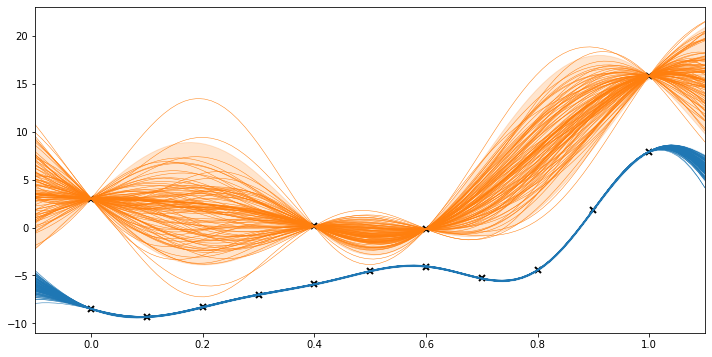

In [14]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)


## predict mean and variance of latent GP at test points
mean_c, var_c = models[0].predict_f(xx)

mean_e, var_e = models[1].predict_f(xx)
## generate 10 samples from posterior
samples_c= models[0].predict_f_samples(xx, 100)  # shape (10, 100, 1)
samples_e = models[1].predict_f_samples(xx, 100)  # shape (10, 100, 1)
## plot 
plt.figure(figsize=(12, 6))
plt.plot(initial_data_c[OBJECTIVE].query_points[:], initial_data_c[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(initial_data_e[OBJECTIVE].query_points[:], initial_data_e[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean_e, 'C1', lw=2)
plt.plot(xx, mean_c, 'C0', lw=2)

plt.fill_between(xx[:,0],
                 mean_c[:,0] - 1.96 * np.sqrt(var_c[:,0]),
                 mean_c[:,0] + 1.96 * np.sqrt(var_c[:,0]),
                 color='C0', alpha=0.2)
plt.fill_between(xx[:,0],
                 mean_e[:,0] - 1.96 * np.sqrt(var_e[:,0]),
                 mean_e[:,0] + 1.96 * np.sqrt(var_e[:,0]),
                 color='C1', alpha=0.2)
plt.plot(xx, samples_e[:, :, 0].T, 'C1', linewidth=.5)

plt.plot(xx, samples_c[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);


In [15]:
### building the Multi_information_source model  
## Sx~N(mu, sigma_square)
## in this method, each fidelity level is represented by a gaussian process
## with mean mu_m and variance sigma_GP^2
##in addition to that, we consider a second source f uncertainty that is inherent to each IS
## we represent it by a fidelity variance sigma_square_f_m

## the difficulty here is fixing the fidelity variance of each level, wich can be a function of x
## in the article, this variance is provided by an expert 


## here we buil the multi-information-source model 
## int he beginning we consider sigma-square_f to be a function of x 
## we calculate if as the difference the values of the current fidelity level and the highest fidelity model considered to be precise
def Sx(x) :
    l=len(x)
    mean_M, var_M=models[M-1].predict_f(x)
    sigma_square_MF=1/var_M
    mu_MF=mean_M/var_M
    for i in range(M-1):
        mean,sigma_square_GP=models[i].predict_f(x)
        sigma_square_f=np.zeros((l,1))
        for j in range(l):
            sigma_square_f[j,0]= 1/num_initial_points[i]*sum((mean_M[j,0]-initial_data[i][OBJECTIVE].observations[:])**2)
        
        sigma_square_t=sigma_square_GP+sigma_square_f
        sigma_square_MF+=(1/sigma_square_t)
        mu_MF+=(mean/sigma_square_t)
    ## computing the mean and variance of the model 
    sigma_square_MF=(1/sigma_square_MF)
    mu_MF=(sigma_square_MF*mu_MF)
    return( mu_MF,sigma_square_MF)

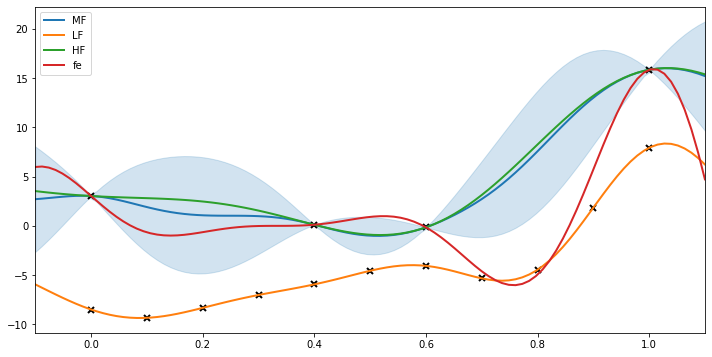

In [16]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)


## predict mean and variance of latent GP at test points
mean, var = Sx(xx)


## plot 
plt.figure(figsize=(12, 6))
plt.plot(initial_data[0][OBJECTIVE].query_points[:], initial_data[0][OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(initial_data[1][OBJECTIVE].query_points[:], initial_data[1][OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean, 'C0',label='MF',lw=2)
plt.plot(xx, mean_c, 'C1', label="LF",lw=2)
plt.plot(xx, mean_e, 'C2',label='HF' , lw=2)
plt.plot(xx, fe(xx), 'C3', label='fe', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

#plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);
plt.legend()


In [21]:
## mu_MF_1
mean_M, var_M=models[M-1].predict_f(xx)
sigma_square_MF=1/var_M
mu_MF=mean_M/var_M ## here we consider that the finest model has zero fidelity variance
mean_c,sigma_square_GP=models[0].predict_f(xx)
sigma_square_f=0.1
sigma_square_t=sigma_square_GP+sigma_square_f
sigma_square_MF+=(1/sigma_square_t)
mu_MF+=(mean_c/sigma_square_t)
## computing the mean and variance of the model 
sigma_square_MF=(1/sigma_square_MF)
mu_MF_1=(sigma_square_MF*mu_MF)


## mu_MF_2
mean_M, var_M=models[M-1].predict_f(xx)
sigma_square_MF=1/var_M
mu_MF=mean_M/var_M
mean_c,sigma_square_GP=models[0].predict_f(xx)
sigma_square_f=1
sigma_square_t=sigma_square_GP+sigma_square_f
sigma_square_MF+=(1/sigma_square_t)
mu_MF+=(mean_c/sigma_square_t)
## computing the mean and variance of the model 
sigma_square_MF=(1/sigma_square_MF)
mu_MF_2=(sigma_square_MF*mu_MF)

## mu_MF_3
mean_M, var_M=models[M-1].predict_f(xx)
sigma_square_MF=1/var_M
mu_MF=mean_M/var_M
mean_c,sigma_square_GP=models[0].predict_f(xx)
sigma_square_f=15
sigma_square_t=sigma_square_GP+sigma_square_f
sigma_square_MF+=(1/sigma_square_t)
mu_MF+=(mean_c/sigma_square_t)
## computing the mean and variance of the model 
sigma_square_MF=(1/sigma_square_MF)
mu_MF_3=(sigma_square_MF*mu_MF)

## mu_MF_4
mean_M, var_M=models[M-1].predict_f(xx)
sigma_square_MF=1/var_M
mu_MF=mean_M/(var_M+0.001)
mean_c,sigma_square_GP=models[0].predict_f(xx)
sigma_square_f=0.1
sigma_square_t=sigma_square_GP+sigma_square_f
sigma_square_MF+=(1/sigma_square_t)
mu_MF+=(mean_c/sigma_square_t)
## computing the mean and variance of the model 
sigma_square_MF=(1/sigma_square_MF)
mu_MF_4=(sigma_square_MF*mu_MF)

## mu_MF_5
mean_M, var_M=models[M-1].predict_f(xx)
sigma_square_MF=1/var_M
mu_MF=mean_M/(var_M+0.001)
mean_c,sigma_square_GP=models[0].predict_f(xx)
sigma_square_f=np.zeros((len(xx),1))
sigma_square_f[:60]=20
sigma_square_f[:60]=0.1
sigma_square_t=sigma_square_GP+sigma_square_f
sigma_square_MF+=(1/sigma_square_t)
mu_MF+=(mean_c/sigma_square_t)
## computing the mean and variance of the model 
sigma_square_MF=(1/sigma_square_MF)
mu_MF_5=(sigma_square_MF*mu_MF)

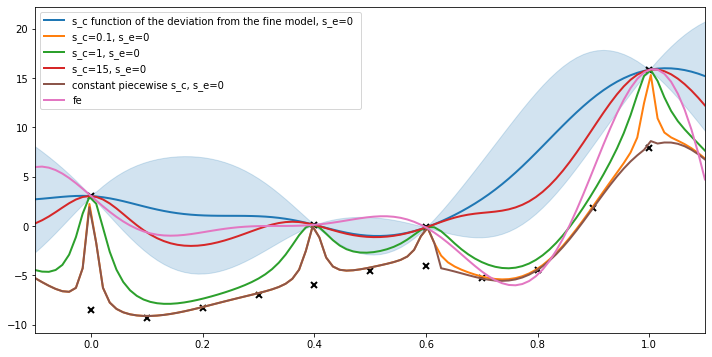

In [22]:
## plot 
plt.figure(figsize=(12, 6))
plt.plot(initial_data[0][OBJECTIVE].query_points[:], initial_data[0][OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(initial_data[1][OBJECTIVE].query_points[:], initial_data[1][OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean, 'C0',label='s_c function of the deviation from the fine model, s_e=0 ',lw=2)
plt.plot(xx, mu_MF_1, 'C1', label="s_c=0.1, s_e=0",lw=2)
plt.plot(xx, mu_MF_2, 'C2',label="s_c=1, s_e=0" , lw=2)
plt.plot(xx, mu_MF_3, 'C3',label="s_c=15, s_e=0" , lw=2)
#plt.plot(xx, mu_MF_4, 'C4',label="s_c=0.1, s_e=0.001" , lw=2)
plt.plot(xx, mu_MF_5, 'C5',label="constant piecewise s_c, s_e=0" , lw=2)
plt.plot(xx, fe(xx), 'C6', label='fe', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)


plt.xlim(-0.1, 1.1);
plt.legend()
